In [150]:
# installing necessary libraries
# !pip install earthengine-api folium matplotlib
# !pip install opencv-python

In [151]:
# importing necessary libraries
import ee
import folium
import numpy as np
import pylab as plt
import cv2
from scipy import stats

In [152]:
# initializing earth engine
ee.Authenticate()
ee.Initialize(project="ee-wavemapping")

In [153]:
from numpy.fft import rfftn, irfftn, fftshift

# borrowed from stuart walsh's examplar code
def cross_correlation(vox1, vox2, remove_median=True):
    '''
    function calculates the cross-correlation output from two input numpy arrays

    parameters:
    vox1 (np.array): image 1
    vox2 (np.array): image 2
    remove_median (Boolean): normalises the image when true

    outputs:
    rv (np.array): cross-correlation output
    '''
    siz = np.array(vox1.shape)*2

    if(remove_median):
        vox1 -= np.median(vox1)
        vox2 -= np.median(vox2)
    
    # cross correlation - padded with zeros
    rv = np.real(fftshift(irfftn(np.conj(rfftn(vox1, siz)) * rfftn(vox2, siz))))

    return rv

In [154]:
def grad_magnitude(sobel_x, sobel_y):   
    '''
    function calculates the gradient magnitudes from sobel outputs

    parameters:
    sobel_x (np.array): sobel gradients in x-direction
    sobel_y (np.array): sobel gradients in y-direction

    outputs:
    mag (np.array): array of gradient magnitudes
    '''
    mag = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
    return mag

In [479]:
def grad_orientation(sobel_x, sobel_y):
    '''
    function calculates and quantizes gradient orientations from sobel outputs

    parameters:
    sobel_x (np.array): sobel gradients in x-direction
    sobel_y (np.array): sobel gradients in y-direction

    outputs:
    ang (np.array): array of gradient orientations
    '''
    # quantizing the angles for non-maximal suppression
    # ang = np.arctan2(sobel_y, sobel_x) * 180/np.pi # converting to degrees for ease in conditional statements
    # ang = (ang % 180)   # Wrap angles between [0, 180]
    # ang = np.where(np.logical_and(0 <= np.abs(ang), np.abs(ang) < 22.5), 0, ang) # rounding angle to 0
    # # ang = np.where(np.abs(ang) > 157.5, 180, ang) # rounding angle to 180
    # ang = np.floor((ang + 22.5) / 45) * 45 # rounding all angles to closest 45 degrees
    # ang = np.where(ang == 0, 180, ang)
    ang = np.arctan2(sobel_y, sobel_x) * 180/np.pi
    ang = (ang % 180)   # Wrap angles between [0, 180]
    ang = np.where(ang < 15, 180, ang)
    return ang

In [407]:
def non_maximal_suppression(grad_magnitude, grad_orientation):
    '''
    function performs non-maximal suppression on the outputs of sobel filtering

    parameters:
    grad_magnitude (np.array): gradient magnitudes calculated from sobel output
    grad_orientation (np.array): gradient orientations calculated from sobel output

    outputs:
    out_mag (np.array): non-maximally suppressed gradient magnitudes
    out_ang (np.array): non-maximally suppressed gradient angles
    '''

    # creating output array
    out_mag = np.zeros(grad_magnitude.shape)
    out_ang = np.zeros(grad_magnitude.shape)

    for r in range(1, grad_orientation.shape[0] - 1):
        for c in range(1, grad_orientation.shape[1] - 1):
            ang = grad_orientation[r,c].astype(int) # converting to integer just for ease of conditions
            mag = grad_magnitude[r,c]
            
            # finding neighbouring cells based on gradient orientation
            if ang == 0 or ang == 180 or ang == -180:
                prev = grad_magnitude[r,c-1]
                next = grad_magnitude[r,c+1]

            elif ang == 90 or ang == -90:
                prev = grad_magnitude[r-1,c]
                next = grad_magnitude[r+1,c]

            elif ang == 45 or ang == -135:
                prev = grad_magnitude[r-1,c+1]
                next = grad_magnitude[r+1,c-1]

            elif ang == 135 or ang == -45:
                prev = grad_magnitude[r-1, c-1]
                next = grad_magnitude[r+1,c+1]

            # thresholding pixel based on neighbours
            if mag >= prev and mag >= next:
                out_mag[r,c] = mag
                out_ang[r,c] = ang


    return out_mag, out_ang
            

In [408]:
def wave_direction_map(band_np, grid_n, gauss_k_size, gauss_sigmaX, sobel_k, gauss_on=True):
    '''
    function creates a wave directional map in a grid format
    
    parameters:
    band_np (np.array): array of energy band in focus
    grid_n (int): number of grid segments in both x and y directions

    returns:
    np.array: vector map
    '''
    
    item_db = np.array(band_np, dtype=float)

    # applying gaussian blur to input
    gauss_out = item_db
    if gauss_on:
        # gauss_k_size = 3
        # gauss_sigmaX = 2
        gauss_out = cv2.GaussianBlur(item_db, (gauss_k_size, gauss_k_size), gauss_sigmaX)

    # finding the average gradients of grid-segmented image
    grid_size = [int((gauss_out.shape[0] + grid_n - 1) // grid_n), int((gauss_out.shape[1] + grid_n - 1) // grid_n)]    # finding the grid size based on number of segments specified 
    output = np.zeros((grid_n, grid_n))     # creating output array
    for i in range(0, gauss_out.shape[0], grid_size[0]):
        for j in range(0, gauss_out.shape[1], grid_size[1]):
            # segmenting image
            segment = gauss_out[i:i+grid_size[0], j:j+grid_size[1]]

            # computing cross-correlation
            cc = cross_correlation(segment, segment)

            # computing sobel gradients
            grad_x = cv2.Sobel(cc, cv2.CV_64F, 1, 0, ksize=sobel_k)
            grad_y = cv2.Sobel(cc, cv2.CV_64F, 0, 1, ksize=sobel_k)

            # computing gradient orientations based on sobel outputs
            grad_dir_out = grad_orientation(grad_x, grad_y)

            # finding the average gradient of the segment
            output[i//grid_size[0], j//grid_size[1]] = np.mean(grad_dir_out)

    # returning output
    return output

In [477]:
def plot_arrows(vect_x, vect_y, out_dim, grid_n, arrow_scale):
    '''
    function plots the vector directions on an existing figure

    parameters:
    vect_x (np.array): vector map in x-direction
    vect_y (np.array): vector map in y-direction
    out_dim (int): output dimension
    grid_n (int): number of grid segments in both x and y directions
    arrow_scale (float): arrows scaling factor
    '''
    # calculating scaling factor in x and y directions
    grid_scale = [int(np.floor(out_dim[0] / grid_n)), int(np.floor(out_dim[1] / grid_n))]
    
    # assuming vect_x and vect_y are same dimensions
    for i in range(0, vect_x.shape[0]):
        for j in range(0, vect_x.shape[1]):
            plt.quiver(i*grid_scale[1] + grid_scale[1]//2, j*grid_scale[0] + grid_scale[0]//2, vect_x[i,j], -vect_y[i,j], scale=arrow_scale, color='red', width=0.005)

In [454]:
def plot_vector_map(band_np, vector_map, grid_n, img_size):
    '''
    function plots the original image band with directions

    parameters:
    band_np (np.array): original image band
    vector_map (np.array): array of calculated angles in image grid
    grid_n (int): number of grid segments
    '''
    item_db = np.array(band_np, dtype=float)

    # converting angle map into vectors
    vect_x = np.cos(vector_map * np.pi / 180)
    vect_y = np.sin(vector_map * np.pi / 180)

    # plotting both original image and vector arrows
    plt.figure(figsize=(img_size, img_size))
    
    plt.imshow(item_db)
    plot_arrows(vect_x=vect_x, vect_y=vect_y, out_dim=item_db.shape, grid_n=grid_n, arrow_scale=25)

    plt.title('output with directions')
    plt.axis('off')
    plt.show()

In [455]:
# importing earth libraries
imageCollection = ee.ImageCollection("COPERNICUS/S1_GRD")
imageCollection2 = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")

In [456]:
# loading dataset
DATASET_NAME = 'COPERNICUS/S2'
DATE_START = ee.Date('2022-01-01')
DATE_END = ee.Date('2022-03-01')
CLOUDY_TOLERANCE = 20

dataset = ee.ImageCollection(DATASET_NAME).filterDate(DATE_START, DATE_END).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUDY_TOLERANCE))


In [457]:
# choosing coordinates and image data filters
ee.Initialize()
# choosing sample region
# COORDINATE = [151.7232483,-23.53207833]
COORDINATE_LIST = [
    [151.7232483,-23.53207833],
    [145,-39],
    [142.645, -39.0947],
    [142.0747, -38.6325],
    [141.3556, -38.5933],       # Near Warnambool
    [147.48238, -38.2690],      # East coast
    [-39.863535, 143.390456]    # West of king island
]
# COORDINATE = COORDINATE_LIST[2]
COORDINATE = COORDINATE_LIST[4]
# COORDINATE = [145,-39]
OFFSET = 0.01 # defines the range of region from centre coordinate

# obtaining rectangle region
lat = COORDINATE[1]
lon = COORDINATE[0]
rectangle = ee.Geometry.Rectangle(lon-OFFSET, lat-OFFSET, lon+OFFSET, lat+OFFSET)
xy = ee.Geometry.Point([lat, lon])

dataset = dataset.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
dataset_region = dataset.filterBounds(rectangle)

sample_img = dataset_region.first()
bands_master = sample_img.sampleRectangle(rectangle)


In [458]:
# showing the chosen region on the map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
rgbVis = {
  "min": 0.0,
  "max": 3000.,
  "gamma":1.6,
  #"bands": ['B8', 'B8', 'B8'],
  "bands": ['B4', 'B3', 'B2'],
}

my_map = folium.Map(location=[lat, lon], zoom_start=15, height=500)
# add the elevation model to the map object.
my_map.add_ee_layer(sample_img, rgbVis, 'RGB')

my_map.add_child(folium.LayerControl())
folium.Marker([lat,lon], tooltip="current location").add_to(my_map)

display(my_map)

In [459]:
# creating an array for each of the bands within the sample image
bands = [
    np.array(bands_master.get("B1").getInfo()),
    np.array(bands_master.get("B2").getInfo()),
    np.array(bands_master.get("B3").getInfo()),
    np.array(bands_master.get("B4").getInfo()),
    np.array(bands_master.get("B5").getInfo()),
    np.array(bands_master.get("B6").getInfo()),
    np.array(bands_master.get("B7").getInfo()),
    np.array(bands_master.get("B8").getInfo()),
    np.array(bands_master.get("B8a").getInfo()),
    np.array(bands_master.get("B9").getInfo()),
    np.array(bands_master.get("B10").getInfo()),
    np.array(bands_master.get("B11").getInfo()),
    np.array(bands_master.get("B12").getInfo())
]

In [460]:
# changing plotting style
plt.style.use('dark_background')

In [461]:
# showing different bands
# h, w = [2, 4]
# fig, axes = plt.subplots(h, w, figsize=(20, 10))

# for b in range(0, 8):
#     axes[b//w, b%w].imshow(bands[b], aspect='auto')
#     axes[b//w, b%w].set_title(f'Band {b+1}')
#     axes[b//w, b%w].set_axis_off()

# plt.tight_layout()
# plt.show()


In [462]:
# choosing band 4 for testing
band_B4_np = np.array(bands_master.get("B4").getInfo())

# defining parameters
grid_n = 9 # this is the number of segments

# converting to np.array with dtype=float
item_db = np.array(band_B4_np, dtype=float)

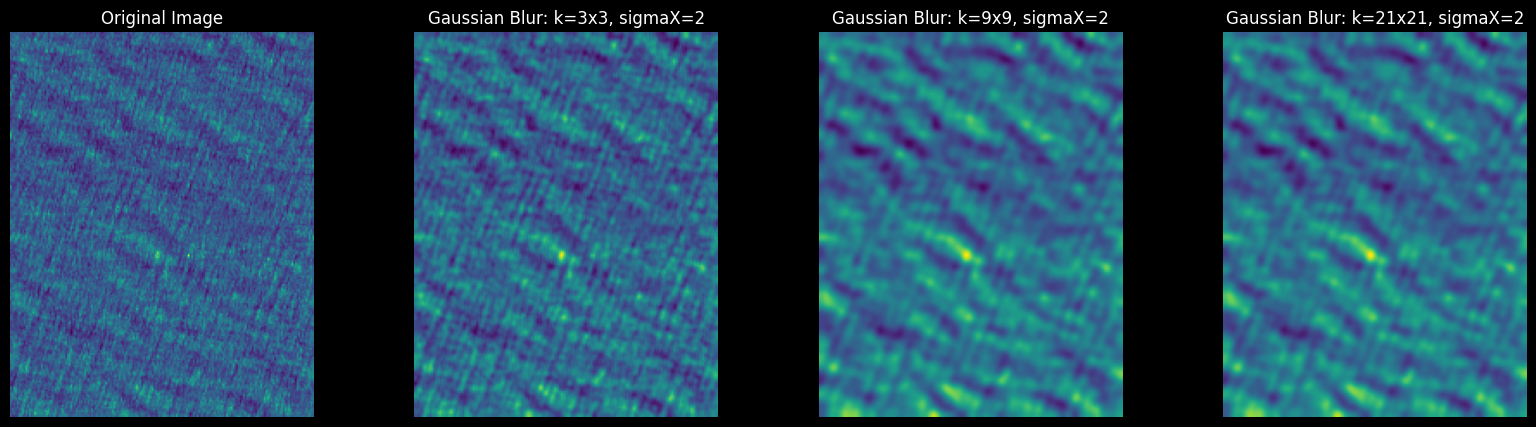

In [463]:
# influence of changing gaussian kernel size
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

k_sizes = [3, 9, 21]

# applying gaussian blur to input
axes[0].imshow(item_db)
axes[0].set_title('Original Image')
axes[0].set_axis_off()

for i, k in enumerate(k_sizes):
    gauss_out = cv2.GaussianBlur(item_db, (k, k), 2)
    axes[i+1].imshow(gauss_out)
    axes[i+1].set_title(f'Gaussian Blur: k={k}x{k}, sigmaX=2')
    axes[i+1].set_axis_off()

plt.show()


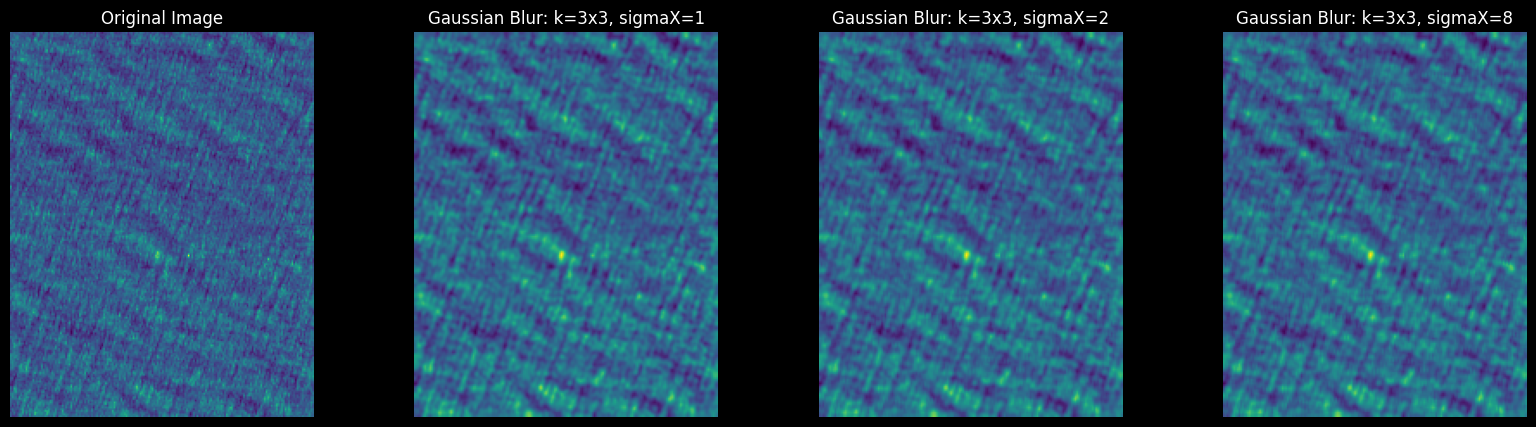

In [464]:
# influence of changing gaussian standard deviation factor (sigmaX)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sigmaX_values = [1, 2, 8]

# applying gaussian blur to input
axes[0].imshow(item_db)
axes[0].set_title('Original Image')
axes[0].set_axis_off()

for i, sigmaX in enumerate(sigmaX_values):
    gauss_out = cv2.GaussianBlur(item_db, (3, 3), sigmaX)
    axes[i+1].imshow(gauss_out)
    axes[i+1].set_title(f'Gaussian Blur: k=3x3, sigmaX={sigmaX}')
    axes[i+1].set_axis_off()

plt.show()


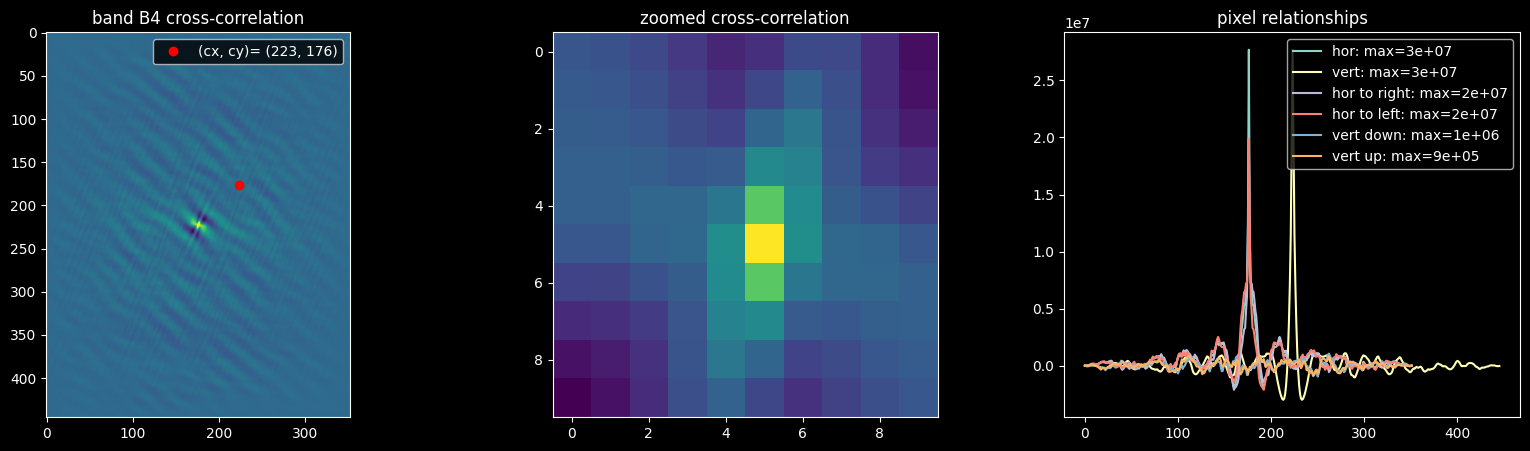

Pixel Relationship Summary:

hor:		3e+07
vert:		3e+07
hor right:	2e+07
hor left:	2e+07
vert down:	1e+06
vert up:	9e+05


In [465]:
# plotting cross-correlation output for band 4
cc = cross_correlation(item_db, item_db)

# determining 'random' reference coordinate
cx, cy = item_db.shape
cutoff = 1*cc[cx-1, cy-1]

# plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# shows the general cross-correlation
ax[0].imshow(cc, vmax=cutoff)
ax[0].plot(cx, cy, 'ro', label=f'(cx, cy)= ({cx}, {cy})')
ax[0].set_title('band B4 cross-correlation')
ax[0].legend()

# showing a zoomed-in version of the cross-correlation
ax[1].imshow(cc[cx-5:cx+5,cy-5:cy+5])
ax[1].set_title('zoomed cross-correlation')

# shows the pixel locations that share the closest features
ax[2].plot(cc[cx,:], label=f'hor: max={np.max(cc[cx,:]):.0e}') # horizontal axis
ax[2].plot(cc[:,cy], label=f'vert: max={np.max(cc[:,cy]):.0e}') # vertical axis
ax[2].plot(cc[cx+1,:], label=f'hor to right: max={np.max(cc[cx+1,:]):.0e}') # horizontal axis offset right by 1
ax[2].plot(cc[cx-1,:], label=f'hor to left: max={np.max(cc[cx-1,:]):.0e}') # horizontal axis offset left by 1
ax[2].plot(cc[cy+1,:], label=f'vert down: max={np.max(cc[cy+1,:]):.0e}') # vertical axis offset down by 1
ax[2].plot(cc[cy-1,:], label=f'vert up: max={np.max(cc[cy-1,:]):.0e}') # vertical axis offset up by 1

ax[2].set_title('pixel relationships')
ax[2].legend()

# showing the subplot
plt.show()

# printing summary of pixel relationships
print(f'Pixel Relationship Summary:\n\nhor:\t\t{np.max(cc[cx,:]):.0e}\nvert:\t\t{np.max(cc[:,cy]):.0e}\nhor right:\t{np.max(cc[cx+1,:]):.0e}\nhor left:\t{np.max(cc[cx-1,:]):.0e}\nvert down:\t{np.max(cc[cy+1,:]):.0e}\nvert up:\t{np.max(cc[cy-1,:]):.0e}')

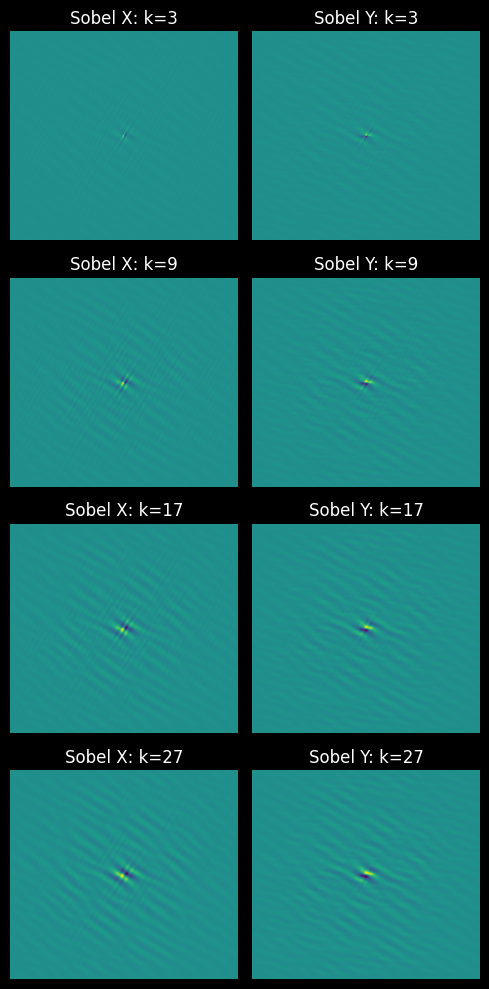

In [466]:
# influence of varying sobel kernel size
fig, axes = plt.subplots(4, 2, figsize=(5, 10))

k_sizes = [3, 9, 17, 27] # chosen randomly

for i, k in enumerate(k_sizes):
    # computing gradients
    grad_x = cv2.Sobel(cc, cv2.CV_64F, 1, 0, ksize=k)
    grad_y = cv2.Sobel(cc, cv2.CV_64F, 0, 1, ksize=k)

    # showing output: sobel X
    axes[i, 0].imshow(grad_x, aspect='auto')
    axes[i, 0].set_title(f'Sobel X: k={k}')
    axes[i, 0].set_axis_off()

    # showing output: sobel Y
    axes[i, 1].imshow(grad_y, aspect='auto')
    axes[i, 1].set_title(f'Sobel Y: k={k}')
    axes[i, 1].set_axis_off()

plt.tight_layout()
plt.show()


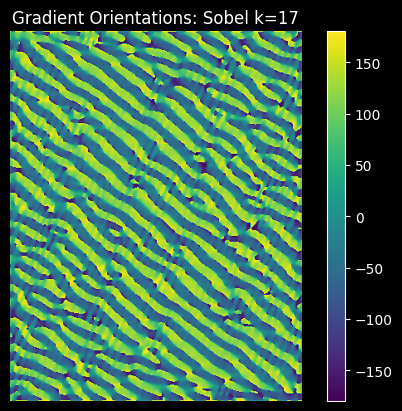

In [467]:
# showing the gradient orientations for k=17
grad_x = cv2.Sobel(cc, cv2.CV_64F, 1, 0, ksize=27)
grad_y = cv2.Sobel(cc, cv2.CV_64F, 0, 1, ksize=27)

grad_dir_out = grad_orientation(grad_x, grad_y)

plt.imshow(grad_dir_out)

plt.title('Gradient Orientations: Sobel k=17')
plt.axis('off')
plt.colorbar()

plt.show()

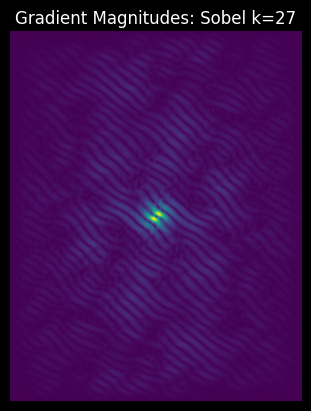

In [468]:
# showing the gradient magnitudes for k=17
grad_mag_out = grad_magnitude(grad_x, grad_y)

plt.imshow(grad_mag_out)

plt.title('Gradient Magnitudes: Sobel k=27')
plt.axis('off')

plt.show()

In [469]:
def wave_direction_map2(gradient_image, grid_n):
    grid_size = [int((gradient_image.shape[0] + grid_n - 1) // grid_n), int((gradient_image.shape[1] + grid_n - 1) // grid_n)]    # finding the grid size based on number of segments specified 
    output = np.zeros((grid_n, grid_n))     # creating output array
    for i in range(0, gradient_image.shape[0], grid_size[0]):
        for j in range(0, gradient_image.shape[1], grid_size[1]):

            segment = gradient_image[i:i+grid_size[0], j:j+grid_size[1]]
            # finding the average gradient of the segment
            output[i//grid_size[0], j//grid_size[1]] = np.mean(segment)

    # returning output
    return output

In [470]:
def low_pass_filter(image, low_freq_radius):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - crow)**2 + (j - ccol)**2) <= low_freq_radius:
                mask[i, j] = 1

    # Apply the high-pass filter
    fshift = fshift * mask

    # Inverse Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize to the range 0-255 and convert to uint8
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back

In [471]:
def individual_wave_direction_map(band_np, grid_n, gauss_k_size, gauss_sigmaX, sobel_k, gauss_on=True):
    '''
    function creates a wave directional map in a grid format
    
    parameters:
    band_np (np.array): array of energy band in focus
    grid_n (int): number of grid segments in both x and y directions

    returns:
    np.array: vector map
    '''
    
    item_db = np.array(band_np, dtype=float)

    # applying gaussian blur to input
    gauss_out = item_db
    if gauss_on:
        # gauss_k_size = 3
        # gauss_sigmaX = 2
        gauss = cv2.GaussianBlur(item_db, (gauss_k_size, gauss_k_size), gauss_sigmaX)
        orig_minus_gauss = item_db - gauss

    # finding the average gradients of grid-segmented image
    grid_size = [int((orig_minus_gauss.shape[0] + grid_n - 1) // grid_n), int((orig_minus_gauss.shape[1] + grid_n - 1) // grid_n)]    # finding the grid size based on number of segments specified 
    output = np.zeros((grid_n, grid_n))     # creating output array
    for i in range(0, orig_minus_gauss.shape[0], grid_size[0]):
        for j in range(0, orig_minus_gauss.shape[1], grid_size[1]):
            # segmenting image
            segment = orig_minus_gauss[i:i+grid_size[0], j:j+grid_size[1]]

            removed_high_freq = low_pass_filter(item_db, low_freq_radius=15)

            grad_x = cv2.Sobel(removed_high_freq, cv2.CV_64F, 1, 0, ksize=sobel_k)
            grad_y = cv2.Sobel(removed_high_freq, cv2.CV_64F, 0, 1, ksize=sobel_k)

            grad_mags = grad_magnitude(grad_x, grad_y)
            grad_angs = grad_orientation(grad_x, grad_y)

            # finding the average gradient of the segment
            output[i//grid_size[0], j//grid_size[1]] = np.mean(grad_angs)

    # returning output
    return output

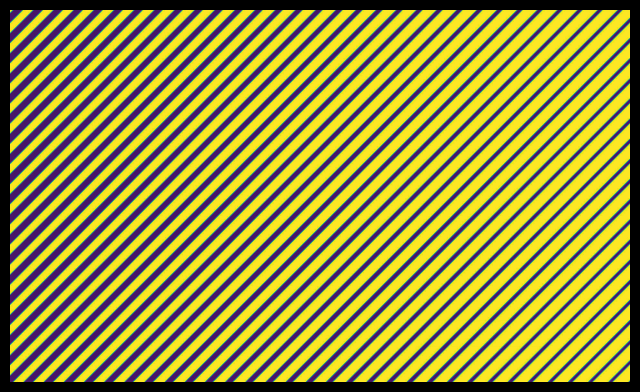

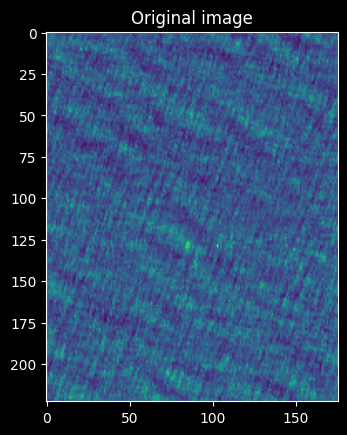

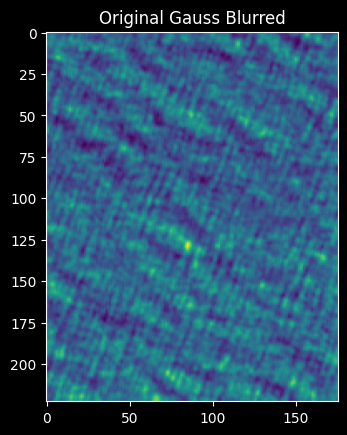

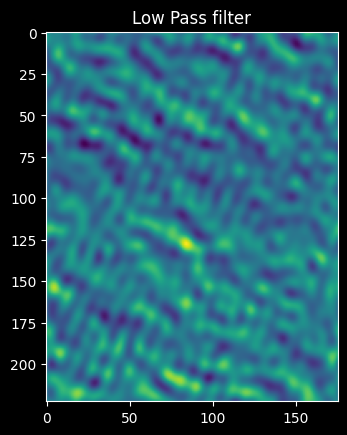

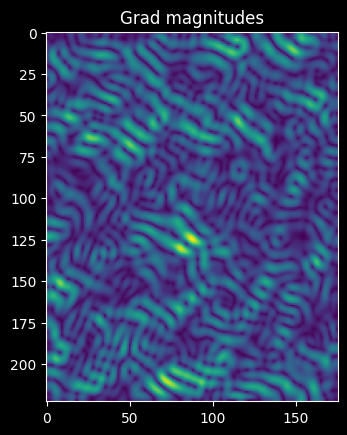

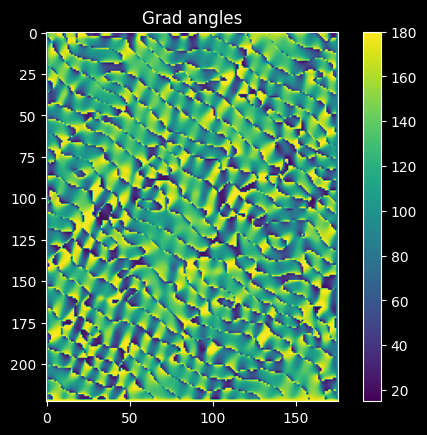

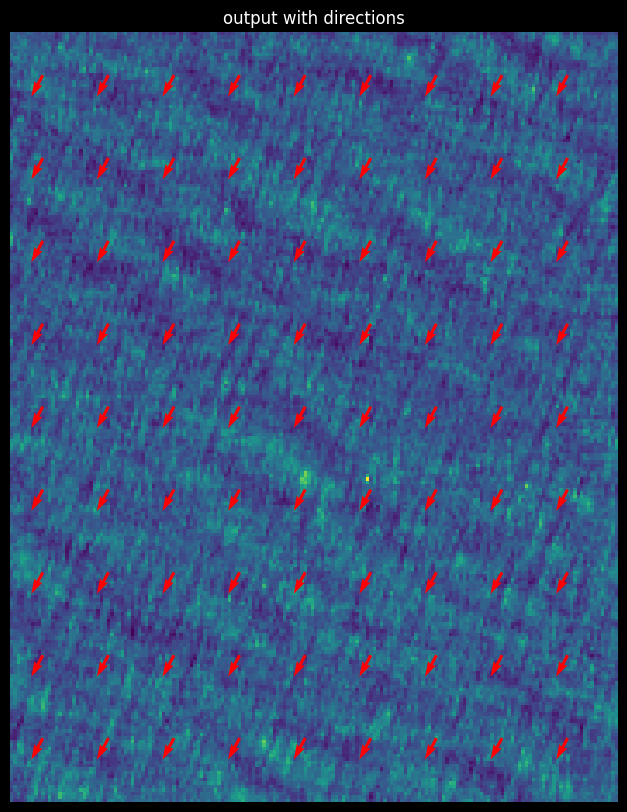

In [480]:
# output: blur on, cc on
# vector_map = wave_direction_map(band_np=band_B4_np, grid_n=grid_n, gauss_k_size=3, gauss_sigmaX=2, sobel_k=17, gauss_on=True) # computing vector map -> stored in vector_map
# plot_vector_map(band_np=band_B4_np, vector_map=vector_map, grid_n=grid_n, img_size=10) # showing the final output image

from PIL import Image

img = Image.open('./diagonal_lines.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

grid_n = 9
gauss_k_size = 3
gauss_sigmaX = 2

item_db = np.array(band_B4_np, dtype=float)
plt.imshow(item_db)
plt.title("Original image")
plt.show()

gauss_image = cv2.GaussianBlur(item_db, (gauss_k_size, gauss_k_size), gauss_sigmaX)
plt.imshow(gauss_image)
plt.title("Original Gauss Blurred")
plt.show()

removed_high_freq = low_pass_filter(item_db, low_freq_radius=20)
plt.imshow(removed_high_freq)
plt.title("Low Pass filter")
plt.show()

# cc + sobel for both directions
# cc = cross_correlation(removed_high_freq, removed_high_freq)
# plt.imshow(cc)
# plt.title("CC (original - gauss blurred)")
# plt.show()

grad_x = cv2.Sobel(removed_high_freq, cv2.CV_64F, 1, 0, ksize=17)
grad_y = cv2.Sobel(removed_high_freq, cv2.CV_64F, 0, 1, ksize=17)

grad_mags = grad_magnitude(grad_x, grad_y)
grad_angs = grad_orientation(grad_x, grad_y)
plt.imshow(grad_mags)
plt.title('Grad magnitudes')
plt.show()
plt.imshow(grad_angs)
plt.title('Grad angles')
plt.colorbar()
plt.show()


# vector_map = wave_direction_map(band_np=grad_dir_out_y, grid_n=grid_n, gauss_k_size=3, gauss_sigmaX=2, sobel_k=17, gauss_on=True)
vector_map = individual_wave_direction_map(band_np=band_B4_np, grid_n=grid_n, gauss_k_size=gauss_k_size, gauss_sigmaX=gauss_sigmaX, sobel_k=17, gauss_on=True)
# vector_map = wave_direction_map2(grad_angs, grid_n=grid_n)
plot_vector_map(band_np=band_B4_np, vector_map=vector_map, grid_n=grid_n, img_size=10)

End Notebook